TAKURA WEKWETE (STUDENT NO u21717215)
MASTERS MIT BIG DATA SCIENCE 


NOVEMBER 2022 (TAKURAWEKWETE@GMAIL.COM OR u21717215@tuks.co.za)


PTHYON CODE FOR CHAPTERS 5 & 8


In [137]:
# Load reinfocement learning libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import random
import scipy.stats as stats
import seaborn as sns
from IPython.core.debugger import set_trace

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
import tensorflow as tf
from collections import namedtuple, deque

In [2]:
tf.version.VERSION

'1.13.1'

In [136]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

TRADITIONAL SOLUTION BASED ON ANALYTICAL APPROACH

In [3]:
#The function below does immunisation by solving 2 simultaneous equations 1)PV(Assets)=PV(Liabilities) and 2) Duration(Assets)=Duration(Liabilities)
def zc_immuniser(m1,m2,liab_duration):  #m1=maturity for zero coupon bond 1 and m2 for zero coupon bond 2
    A=[[1,1],[m1,m2]]   
    B=[1,liab_duration]
    x=np.linalg.solve(A,B)
   
    weight1_interim=x[0]
    weight2_interim=x[1]
    weight1=min(max(weight1_interim,0),1)
    weight2=min(max(weight2_interim,0),1)
    result=np.array([m1,m2,liab_duration,weight1,weight2])
    return result


FUNCTIONS WHICH GENERATE MONTE CARLO SIMULATIONS FOR A SPECIFIED NUMBER OF REQUIRED TIME STEPS

In [16]:
def liability_duration_sim(steps,prob_increase,max_change,duration_start):
    
    duration_change_sign = np.random.choice(a=([1,-1]),p=([prob_increase,1-prob_increase]),size=steps)#increase or decrease 
    magnitude_of_duration_change =np.random.uniform(low=0,high=max_change,size=steps) 
    duration_change = duration_change_sign*magnitude_of_duration_change
    cumulative_duration_change=np.cumsum(duration_change)
    liab_duration_sim=duration_start+cumulative_duration_change

    return(liab_duration_sim)

In [17]:
def asset_term_sim(steps,change_sign,change_size,term_range_start,term_range_end):
    
    term_start = np.random.uniform(low=term_range_start,high=term_range_end,size=1) 
    change_sign_array = np.full((steps,),change_sign) 
    term_change = change_sign_array*change_size
    cumulative_term_change = np.cumsum(term_change)
    asset_term_sim = term_start+cumulative_term_change

    return(asset_term_sim)

In [18]:
def generate_one_simulation(steps,prob_increase,max_change,duration_start):
    one_liability_simulation=liability_duration_sim(steps,prob_increase,max_change,duration_start)
    one_asset1_simulation = asset_term_sim(steps,0,0,10,20)
    one_asset2_simulation = asset_term_sim(steps,0,0,30,40)
    one_simulation = np.stack((one_asset1_simulation,one_asset2_simulation,one_liability_simulation),axis=1)
    return(one_simulation)


In [19]:
def generate_multiple_simulations(steps,number_simulations,max_change=0.5,duration_start=25):

    first_simulation = generate_one_simulation(steps,0.5,max_change,duration_start)
    first_simulation_reshaped = np.reshape(first_simulation,(1,first_simulation.shape[0],first_simulation.shape[1]))
    multiple_simulations = first_simulation_reshaped
    
    for i in np.arange(start=1,stop=number_simulations):
        prob_inc=np.random.uniform(low=0.3,high=0.7)   #specifying the ranges of drift
        ith_simulation = generate_one_simulation(steps,prob_inc,max_change,duration_start)
        ith_simulation_reshaped = np.reshape(ith_simulation,(1,ith_simulation.shape[0],ith_simulation.shape[1]))
        multiple_simulations = np.concatenate((multiple_simulations,ith_simulation_reshaped),axis=0)
    
    multiple_simulations = np.transpose(multiple_simulations,axes=(1,0,2))
    return(multiple_simulations)

In [65]:
#SIMULATING DATA FOR TRAINING FOR RESEARCH QUESTION 1
training_simulation=generate_multiple_simulations(steps=60,max_change=0.5,number_simulations=10000) #SIMULATING DATA FOR A YEAR, WHERE REBALANCING IS DONE EVERY MONTH 
training_simulation.shape

(60, 10000, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

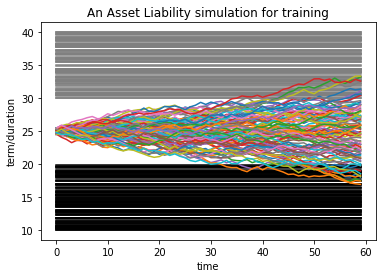

In [66]:
#VISUALISING SOME OF THE SIMULATIONS 
asset1term=training_simulation[:,0:100,0]
asset2term=training_simulation[:,0:100,1]
liabilities_duration=training_simulation[:,0:100,2]
plt.plot(asset1term,color ="black")
plt.plot(asset2term,color = "grey")
plt.plot(liabilities_duration)
plt.xlabel("time")
plt.ylabel("term/duration")
plt.title("An Asset Liability simulation for training")
plt.show

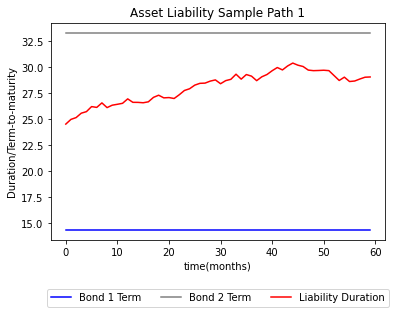

In [450]:
#Simulation 1
sim_index=14 #decreasing liability duration
asset1term=training_simulation[:,sim_index,0]
asset2term=training_simulation[:,sim_index,1]
liabilities_duration=training_simulation[:,sim_index,2]
plt.plot(asset1term,color ="blue",label = "Bond 1 Term")
plt.plot(asset2term,color = "grey" ,label = "Bond 2 Term")
plt.plot(liabilities_duration,color = "red",label = "Liability Duration")
plt.xlabel("time(months)")
plt.ylabel("Duration/Term-to-maturity")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.title("Asset Liability Sample Path 1")
plt.show
plt.savefig('output/s1.png', dpi=300, bbox_inches="tight")

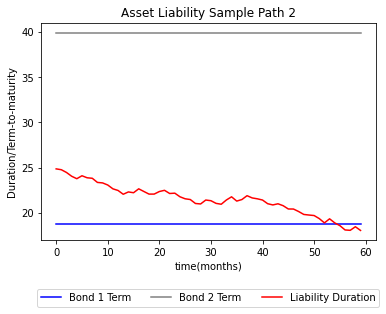

In [452]:
#Simulation 2
sim_index=10 #decreasing liability duration
asset1term=training_simulation[:,sim_index,0]
asset2term=training_simulation[:,sim_index,1]
liabilities_duration=training_simulation[:,sim_index,2]
plt.plot(asset1term,color ="blue",label = "Bond 1 Term")
plt.plot(asset2term,color = "grey" ,label = "Bond 2 Term")
plt.plot(liabilities_duration,color = "red",label = "Liability Duration")
plt.xlabel("time(months)")
plt.ylabel("Duration/Term-to-maturity")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.title("Asset Liability Sample Path 2")
plt.show
plt.savefig('output/s2.png', dpi=300, bbox_inches="tight")


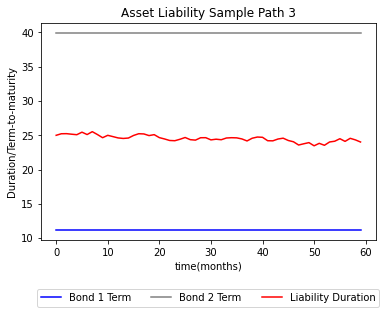

In [360]:
#Simulation 3
sim_index=8 #constant duration
asset1term=training_simulation[:,sim_index,0]
asset2term=training_simulation[:,sim_index,1]
liabilities_duration=training_simulation[:,sim_index,2]
plt.plot(asset1term,color ="blue",label = "Bond 1 Term")
plt.plot(asset2term,color = "grey" ,label = "Bond 2 Term")
plt.plot(liabilities_duration,color = "red",label = "Liability Duration")
plt.xlabel("time(months)")
plt.ylabel("Duration/Term-to-maturity")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.title("Asset Liability Sample Path 3")
plt.show
plt.savefig('output/s3.png', dpi=300, bbox_inches="tight")


DEFINING THE REINFORCEMENT LEARNING AGENT AND REWARDS. THIS IS IMPLEMENTED WITH A RECURRRENT NEURAL NETWORK (RNN/LSTM)

In [67]:
#DEFINING REINFORCEMENT LEARNING AGENT FOR ALM 
from IPython.core.debugger import set_trace

class Agent(object):
    def __init__(self, time_steps, batch_size, features, nodes = [62,46,46,1], name='alm_model1'):
        tf.reset_default_graph()
        self.batch_size = batch_size 
        self.alm_input = tf.placeholder(tf.float32, [time_steps, batch_size, features]) 

        self.asset1= self.alm_input[:,:,0]
        self.asset2= self.alm_input[:,:,1]
        self.liabilities= self.alm_input[:,:,2]

        alm_input_mod = tf.unstack(self.alm_input, axis=0)

        # Build the lstm
        lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(n) for n in nodes])

        self.strategy, state = tf.nn.static_rnn(lstm, alm_input_mod, initial_state=lstm.zero_state(batch_size, tf.float32), dtype=tf.float32)
        #self.strategy = tf.contrib.layers.fully_connected(inputs=alm_input_mod, num_outputs=1,activation_fn=tf.nn.relu)

        self.strategy_mod = tf.reshape(self.strategy, (time_steps, batch_size))

        self.asset1_weight=self.strategy_mod
        self.asset2_weight=tf.ones([time_steps, batch_size], dtype=tf.float32)-self.strategy_mod

        self.errors=tf.math.multiply( self.asset1_weight, self.asset1) + tf.math.multiply(self.asset2_weight, self.asset2) -  self.liabilities  #- tf.ones([time_steps, batch_size], dtype=tf.float32)     #duration mismatch errors
        self.errors_squared = tf.square( self.errors)  #Sum square errors
        self.SSE = tf.reduce_sum(self.errors_squared,axis=0)      
        BATCH_SSE = tf.reduce_mean(self.SSE)

        self.train = tf.train.AdamOptimizer().minimize(BATCH_SSE) #Dynamic learning rate 
        #self.train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(BATCH_SSE) #Synonymous with Stochastic Gradient descent 
        #self.train = tf.train.ProximalGradientDescentOptimizer(learning_rate=0.01).minimize(BATCH_SSE) #Synonymous with Stochastic Gradient descent 

        self.saver = tf.train.Saver()
        self.modelname = name
        
    def _execute_graph_batchwise(self, paths, sess, epochs=1, train_flag=False):
        sample_size = paths.shape[1]
        batch_size=self.batch_size
        idx = np.arange(sample_size)
        start = dt.datetime.now()
        for epoch in range(epochs):
            # Save the ALM mismatch errors for each batch      
            mismatch_errors = []
            strategies = []            
            if train_flag:
                np.random.shuffle(idx)
            for i in range(int(sample_size/batch_size)):
                indices = idx[i*batch_size : (i+1)*batch_size]
                batch = paths[:,indices,:]
                if train_flag:#runs the train, alm SSE and strategy using the inputs 
                    _, SSE, strategy = sess.run([self.train, self.SSE, self.strategy], {self.alm_input: batch})
                else:
                    SSE, strategy = sess.run([self.SSE, self.strategy], {self.alm_input: batch})
                mismatch_errors.append(SSE)
                strategies.append(strategy)

            EPOCH_SSE = np.mean(np.concatenate(mismatch_errors))
            #set_trace()
            if train_flag:
                #if epoch % 10 == 0:
                if epoch % 1 == 0:
                    print('Time elapsed:', dt.datetime.now()-start)
                    print('Epoch', epoch, 'SSE', EPOCH_SSE)
                    #Saving the model
                    self.saver.save(sess, "alm_model1.ckpt")
        self.saver.save(sess, "alm_model1.ckpt")
        return EPOCH_SSE, np.concatenate(mismatch_errors), np.concatenate(strategies,axis=1)
    
    def training(self, paths, epochs, session, init=True):   #DEFINE THE TRAINING FUNCTION 
        if init:
            sess.run(tf.global_variables_initializer())
        self._execute_graph_batchwise(paths, session, epochs, train_flag=True)
        
    def predict(self, paths, session):  #DEFINE THE PREDICTION FUNCTION 
        return self._execute_graph_batchwise(paths,session, 1, train_flag=False)

    def restore(self, session, checkpoint):
        self.saver.restore(session, checkpoint)

In [68]:
#DEFINING THE REINFORMENT LEARNING AGENT OBJECT FOR TRAINING 
batch_size = 1000
features = 3
data = training_simulation

model_1 = Agent(data.shape[0], batch_size, features, name='alm_model1')

In [69]:
#EXECUTING AGENT EXPERIMENTS AND REINFORCEMENT LEARNING TRAINING
epoch=100
start = dt.datetime.now()
with tf.Session() as sess:
    # Train Model
    model_1.training(data, epoch, sess)
print('Training finished, Time elapsed:', dt.datetime.now()-start)

Time elapsed: 0:00:26.299110
Epoch 0 SSE 2021.0608
Time elapsed: 0:00:38.565554
Epoch 1 SSE 936.231
Time elapsed: 0:00:50.938500
Epoch 2 SSE 773.8549
Time elapsed: 0:01:03.735012
Epoch 3 SSE 507.75336
Time elapsed: 0:01:16.779280
Epoch 4 SSE 354.9496
Time elapsed: 0:01:29.931886
Epoch 5 SSE 273.0633
Time elapsed: 0:01:43.129881
Epoch 6 SSE 224.7436
Time elapsed: 0:01:56.426749
Epoch 7 SSE 191.93085
Time elapsed: 0:02:09.755482
Epoch 8 SSE 165.60933
Time elapsed: 0:02:23.319091
Epoch 9 SSE 145.16032
Time elapsed: 0:02:36.841997
Epoch 10 SSE 129.40323
Time elapsed: 0:02:50.417084
Epoch 11 SSE 115.73608
Time elapsed: 0:03:04.286778
Epoch 12 SSE 104.19239
Time elapsed: 0:03:18.082321
Epoch 13 SSE 94.05928
Time elapsed: 0:03:31.742755
Epoch 14 SSE 87.68731
Time elapsed: 0:03:45.254369
Epoch 15 SSE 78.08297
Time elapsed: 0:03:59.044806
Epoch 16 SSE 70.879616
Time elapsed: 0:04:12.700661
Epoch 17 SSE 64.61482
Time elapsed: 0:04:26.533658
Epoch 18 SSE 59.477818
Time elapsed: 0:04:40.616206
Epo

In [37]:
#Visualise training progress
type(model_1)

__main__.Agent

TESTING REINFORCEMENT LEARING AGENT ON UNSEEN TEST DATA

In [76]:
#SIMULATING UNSEEN TESTING DATA

#Simulating data of simular variation 
test_data=generate_multiple_simulations(steps=60,max_change=0.5,number_simulations=1000) 

#Simulating data of increase variation 
test_data2=generate_multiple_simulations(steps=60,max_change=1,number_simulations=1000) 

In [302]:
#TEST DATA 1
#Searching for simulations where the liability duration either goes below the short-term bond or above the long-term bond
breach_indicators=[]
for j in np.arange(test_data.shape[1]):
    for i in np.arange(test_data.shape[0]):
        asset1term=test_data[i,j,0]
        asset2term=test_data[i,j,1]
        liabilities_duration=test_data[i,j,2]
        breach_indicator=0
        if liabilities_duration<asset1term or liabilities_duration>asset2term:
            #print("flag",i,j)
            breach_indicator=1
    breach_indicators=np.append(breach_indicators,breach_indicator)

non_breach_indices=np.argwhere(breach_indicators==0)
breach_indices=np.argwhere(breach_indicators==1)

In [303]:
#TEST DATA 2
#Searching for simulations where the liability duration either goes below the short-term bond or above the long-term bond
breach_indicators2=[]
for j in np.arange(test_data2.shape[1]):
    for i in np.arange(test_data2.shape[0]):
        asset1term=test_data2[i,j,0]
        asset2term=test_data2[i,j,1]
        liabilities_duration=test_data2[i,j,2]
        breach_indicator=0
        if liabilities_duration<asset1term or liabilities_duration>asset2term:
            #print("flag",i,j)
            breach_indicator=1
    breach_indicators2=np.append(breach_indicators2,breach_indicator)

non_breach_indices2=np.argwhere(breach_indicators2==0)
breach_indices2=np.argwhere(breach_indicators2==1)

In [325]:
td=test_data[:,non_breach_indices,:]
tdt=np.reshape(td,newshape=(60,959,3))
tdt.shape

(60, 959, 3)

In [329]:
#Visualise BREACH TEST DATA

# vis_index=369 #decreasing liability duration
# asset1term=tdt[:,vis_index,0]
# asset2term=tdt[:,vis_index,1]
# liabilities_duration=tdt[:,vis_index,2]
# plt.plot(asset1term,color ="blue",label = "Bond 1 Term")
# plt.plot(asset2term,color = "grey" ,label = "Bond 2 Term")
# plt.plot(liabilities_duration,color = "red",label = "Liability Duration")
# plt.xlabel("time(months)")
# plt.ylabel("Duration/Term-to-maturity")
# plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
# plt.title("Asset Liability Sample Path")
# plt.show

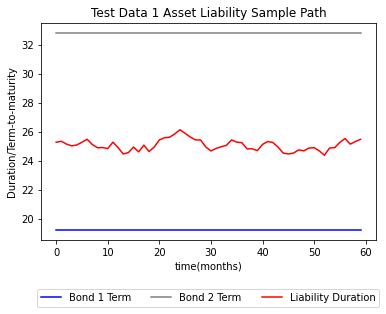

In [339]:
#Visualise FULL TEST DATA 1
vis_index=369 #this sample has a high error -> requires additional investigation
asset1term=test_data[:,vis_index,0]
asset2term=test_data[:,vis_index,1]
liabilities_duration=test_data[:,vis_index,2]
plt.plot(asset1term,color ="blue",label = "Bond 1 Term")
plt.plot(asset2term,color = "grey" ,label = "Bond 2 Term")
plt.plot(liabilities_duration,color = "red",label = "Liability Duration")
plt.xlabel("time(months)")
plt.ylabel("Duration/Term-to-maturity")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.title("Test Data 1 Asset Liability Sample Path")
plt.show
#plt.savefig('output/s2.png', dpi=300, bbox_inches="tight")

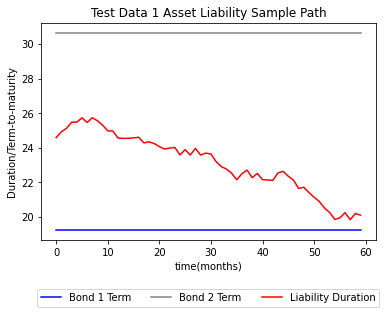

In [366]:
#Visualise FULL TEST DATA 1
vis_index=6 #this sample has a high error -> requires additional investigation
asset1term=test_data[:,vis_index,0]
asset2term=test_data[:,vis_index,1]
liabilities_duration=test_data[:,vis_index,2]
plt.plot(asset1term,color ="blue",label = "Bond 1 Term")
plt.plot(asset2term,color = "grey" ,label = "Bond 2 Term")
plt.plot(liabilities_duration,color = "red",label = "Liability Duration")
plt.xlabel("time(months)")
plt.ylabel("Duration/Term-to-maturity")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.title("Test Data 1 Asset Liability Sample Path")
plt.show
plt.savefig('output/ts1.png', dpi=300, bbox_inches="tight")

In [370]:
#test data 1 at annual intervals 
np.round(test_data[[11,23,35,47,59],vis_index,:],2)

array([[19.22, 30.66, 24.97],
       [19.22, 30.66, 24.02],
       [19.22, 30.66, 22.15],
       [19.22, 30.66, 21.65],
       [19.22, 30.66, 20.1 ]])

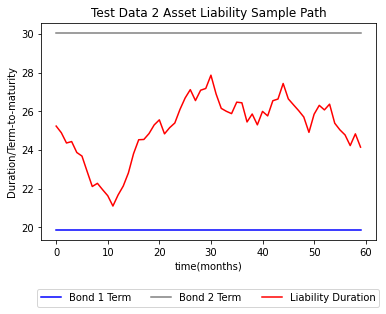

In [373]:
#Visualise TEST DATA 2
vis_index2=4 #decreasing liability duration
asset1term=test_data2[:,vis_index2,0]
asset2term=test_data2[:,vis_index2,1]
liabilities_duration=test_data2[:,vis_index2,2]
plt.plot(asset1term,color ="blue",label = "Bond 1 Term")
plt.plot(asset2term,color = "grey" ,label = "Bond 2 Term")
plt.plot(liabilities_duration,color = "red",label = "Liability Duration")
plt.xlabel("time(months)")
plt.ylabel("Duration/Term-to-maturity")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.title("Test Data 2 Asset Liability Sample Path")
plt.show
plt.savefig('output/ts2.png', dpi=300, bbox_inches="tight")


In [374]:
#test data 2 at annual intervals 
np.round(test_data2[[11,23,35,47,59],vis_index2,:],2)

array([[19.83, 30.07, 21.1 ],
       [19.83, 30.07, 25.4 ],
       [19.83, 30.07, 26.48],
       [19.83, 30.07, 26.04],
       [19.83, 30.07, 24.15]])

In [77]:
#RUNNING THE REINFORCEMENT LEARNING ON TEST DATA (TEST DATA 1)
#Analysing results
with tf.Session() as sess:
    model_1.restore(sess, 'alm_model1.ckpt')
    #Using the model_1 trained in the section above
    test_results = model_1.predict(test_data, sess)

INFO:tensorflow:Restoring parameters from alm_model1.ckpt


In [78]:
#RUNNING THE REINFORCEMENT LEARNING ON TEST DATA (TEST DATA 2)
#Analysing results
with tf.Session() as sess:
    model_1.restore(sess, 'alm_model1.ckpt')
    #Using the model_1 trained in the section above
    test_results2 = model_1.predict(test_data2, sess)

INFO:tensorflow:Restoring parameters from alm_model1.ckpt


In [243]:
#Average testing SSE
test_results[0]

2.4282453

<function matplotlib.pyplot.show(close=None, block=None)>

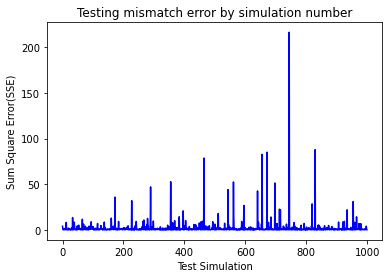

In [312]:
#MISMATCH ERRORS ALL TEST DATA
plt.plot(test_results[1],color ="blue") 
#plt.plot(np.full((len(test_results[1]),),test_results[0]),color ="red")
plt.xlabel("Test Simulation")
plt.ylabel("Sum Square Error(SSE)")
plt.title('Testing mismatch error by simulation number')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

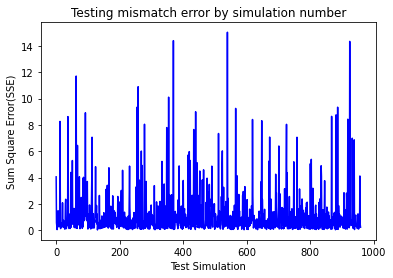

In [317]:
#MISMATCH ERRORS NON BREACH DATA
#plt.plot(test_results[1],color ="blue") 
plt.plot(test_results[1][non_breach_indices],color ="blue") 
#plt.plot(np.full((len(test_results[1]),),test_results[0]),color ="red")
plt.xlabel("Test Simulation")
plt.ylabel("Sum Square Error(SSE)")
plt.title('Testing mismatch error by simulation number')
plt.show

In [327]:
np.argwhere(test_results[1][non_breach_indices]>12)

array([[369,   0],
       [539,   0],
       [924,   0]])

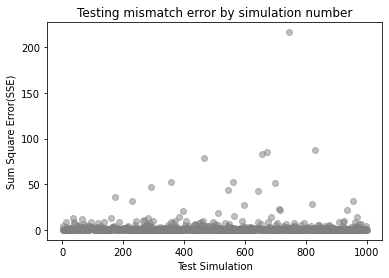

In [315]:
#colors = np.random.rand(len(test_results[1]))
x=np.arange(len(test_results[1]))+1
#x=np.arange(len(test_results[1][non_breach_indices]))+1
y=test_results[1]
#y=test_results[1][non_breach_indices]
plt.scatter(x, y, c="grey", alpha=0.5)
#plt.plot(np.full((len(test_results[1]),),test_results[0]),color ="red",linestyle='--')

plt.xlabel("Test Simulation")
plt.ylabel("Sum Square Error(SSE)")
plt.title('Testing mismatch error by simulation number')
plt.show()

(array([445., 211., 100.,  55.,  30.,  28.,  13.,  13.,  12.,  10.,   8.,
          4.,   2.,   2.,   4.,   2.,   6.,   5.,   3.,   0.,   1.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   2.,   1.]),
 array([ 0.03103174,  0.5308976 ,  1.0307635 ,  1.5306294 ,  2.0304952 ,
         2.5303612 ,  3.030227  ,  3.530093  ,  4.0299587 ,  4.5298247 ,
         5.0296907 ,  5.5295563 ,  6.0294223 ,  6.5292883 ,  7.029154  ,
         7.52902   ,  8.028886  ,  8.528751  ,  9.028618  ,  9.528483  ,
        10.028349  , 10.528215  , 11.028081  , 11.527946  , 12.027813  ,
        12.5276785 , 13.027545  , 13.5274105 , 14.027276  , 14.527143  ,
        15.027008  ], dtype=float32),
 <BarContainer object of 30 artists>)

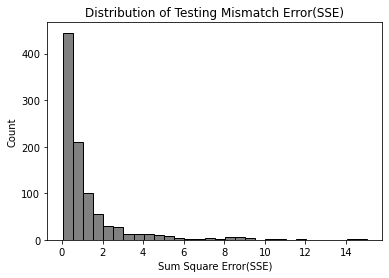

In [314]:
plt.xlabel("Sum Square Error(SSE)")
plt.ylabel("Count")
plt.title("Distribution of Testing Mismatch Error(SSE)")
plt.hist(test_results[1][non_breach_indices],density=0,bins=30,color="grey",ec="black")

(array([213., 164., 116.,  98.,  59.,  43.,  43.,  25.,  23.,  23.,  16.,
         13.,   9.,  16.,   9.,   5.,   5.,   6.,   4.,   6.,   8.,   2.,
          5.,   4.,   6.,   2.,   6.,   1.,   0.,   1.,   4.,   0.,   3.,
          0.,   2.,   3.,   1.,   1.,   1.,   1.,   1.,   1.,   4.,   1.,
          3.,   4.,   0.,   5.,   0.,   2.]),
 array([0.03103174, 0.22649176, 0.4219518 , 0.61741185, 0.8128719 ,
        1.0083319 , 1.203792  , 1.3992519 , 1.594712  , 1.790172  ,
        1.9856321 , 2.181092  , 2.376552  , 2.5720122 , 2.7674723 ,
        2.962932  , 3.1583922 , 3.3538523 , 3.5493124 , 3.7447724 ,
        3.9402323 , 4.1356926 , 4.3311524 , 4.5266123 , 4.7220726 ,
        4.9175324 , 5.112993  , 5.3084526 , 5.5039124 , 5.699373  ,
        5.8948326 , 6.090293  , 6.285753  , 6.4812126 , 6.676673  ,
        6.872133  , 7.0675926 , 7.263053  , 7.458513  , 7.653973  ,
        7.849433  , 8.044893  , 8.240353  , 8.435813  , 8.631273  ,
        8.826734  , 9.022193  , 9.217653  , 9.

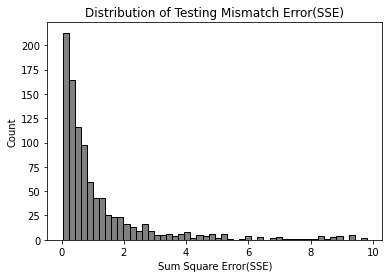

In [239]:
#figure, axis = plt.subplots(1, 2)
cut_off=10
plt.xlabel("Sum Square Error(SSE)")
plt.ylabel("Count")
plt.title("Distribution of Testing Mismatch Error(SSE)")
plt.hist(test_results[1][np.argwhere(test_results[1]<cut_off)],density=0,bins=50,color="grey",ec="black")

In [216]:
# #colors = np.random.rand(len(test_results[1]))
# x=np.arange(len(test_results2[1]))+1
# y=test_results2[1]
# plt.scatter(x, y, c="grey", alpha=0.5)
# plt.xlabel("simulation")
# plt.ylabel("SSE")
# plt.title('Training mismatch error by simulation number')
# plt.show()

In [81]:
#TEST DATA PERFORMANCE (VISUALISATION)
weights_predictions_test_interim = test_results[2]
weights_predictions_test = np.reshape(weights_predictions_test_interim,(weights_predictions_test_interim.shape[0],weights_predictions_test_interim.shape[1]))
weights_predictions_test

array([[0.571336  , 0.5221952 , 0.46863422, ..., 0.5706225 , 0.44147712,
        0.52383035],
       [0.66826725, 0.54391235, 0.44034505, ..., 0.6655104 , 0.41699767,
        0.5377774 ],
       [0.6793421 , 0.5374031 , 0.39222738, ..., 0.6542241 , 0.4115596 ,
        0.51884115],
       ...,
       [0.6204863 , 0.23415068, 0.566217  , ..., 0.54089975, 0.28216437,
        0.40017527],
       [0.60582954, 0.25578302, 0.54232776, ..., 0.52643603, 0.27843794,
        0.38706067],
       [0.6256996 , 0.26121336, 0.5449303 , ..., 0.5409161 , 0.26526028,
        0.40833807]], dtype=float32)

In [124]:
weights_predictions_test_interim2 = test_results2[2]
weights_predictions_test2 = np.reshape(weights_predictions_test_interim2,(weights_predictions_test_interim2.shape[0],weights_predictions_test_interim2.shape[1]))
weights_predictions_test2

array([[0.5283096 , 0.5289933 , 0.57436174, ..., 0.41702798, 0.54548895,
        0.5314064 ],
       [0.57350564, 0.5830487 , 0.67529684, ..., 0.36946297, 0.60866994,
        0.5722576 ],
       [0.5596367 , 0.57165205, 0.64255327, ..., 0.36363366, 0.61681664,
        0.55612713],
       ...,
       [0.6461919 , 0.8700532 , 0.0613778 , ..., 0.44674066, 0.05604264,
        0.691991  ],
       [0.67204094, 0.8673267 , 0.05630304, ..., 0.48081464, 0.05128231,
        0.64653206],
       [0.675788  , 0.87827224, 0.04996864, ..., 0.48387682, 0.04532437,
        0.6025934 ]], dtype=float32)

In [140]:
#CHECKING THE RANGE OF WEIGHTS 
np.min(weights_predictions_test),np.max(weights_predictions_test)
#Range between 0 and 1

(0.008593439, 0.9907939)

In [84]:
analytical_weights_test=np.full((test_data.shape[0],test_data.shape[1]),fill_value=0.0)
for i in np.arange(test_data.shape[0]):
    for j in np.arange(test_data.shape[1]):
        data_point=test_data[i][j]
        #print(data_point)
        t1=data_point[0]
        t2=data_point[1]
        tl=data_point[2]
        analytical_weight= zc_immuniser(t1,t2,tl)[3]
        #print(analytical_weight)
        analytical_weights_test[i,j] = analytical_weight
analytical_weights_test

array([[0.68147517, 0.5432946 , 0.44158063, ..., 0.6808719 , 0.43050064,
        0.53612175],
       [0.65920644, 0.54271001, 0.42052272, ..., 0.65563876, 0.43557582,
        0.53047542],
       [0.67331414, 0.53310378, 0.3878745 , ..., 0.6395006 , 0.41664791,
        0.51051065],
       ...,
       [0.62096093, 0.24795004, 0.56368429, ..., 0.54300851, 0.28657597,
        0.40293602],
       [0.60602175, 0.27275066, 0.54006944, ..., 0.52875203, 0.27977321,
        0.38890382],
       [0.62507416, 0.26924968, 0.54419334, ..., 0.54058566, 0.26268449,
        0.40739799]])

In [125]:
analytical_weights_test2=np.full((test_data2.shape[0],test_data2.shape[1]),fill_value=0.0)
for i in np.arange(test_data2.shape[0]):
    for j in np.arange(test_data2.shape[1]):
        data_point=test_data2[i][j]
        #print(data_point)
        t1=data_point[0]
        t2=data_point[1]
        tl=data_point[2]
        analytical_weight= zc_immuniser(t1,t2,tl)[3]
        #print(analytical_weight)
        analytical_weights_test2[i,j] = analytical_weight
analytical_weights_test2

array([[0.55031213, 0.55159449, 0.67975684, ..., 0.40066669, 0.58283847,
        0.55957644],
       [0.57184417, 0.58214063, 0.66233353, ..., 0.36874798, 0.60253539,
        0.57909952],
       [0.55322992, 0.57115253, 0.62785593, ..., 0.37153766, 0.61424439,
        0.54404135],
       ...,
       [0.64611339, 0.86048028, 0.05796015, ..., 0.450014  , 0.0731183 ,
        0.69640348],
       [0.67172636, 0.85478651, 0.07779199, ..., 0.47906953, 0.05507986,
        0.64332446],
       [0.67674482, 0.88665462, 0.04559415, ..., 0.48342877, 0.03661131,
        0.6007049 ]])

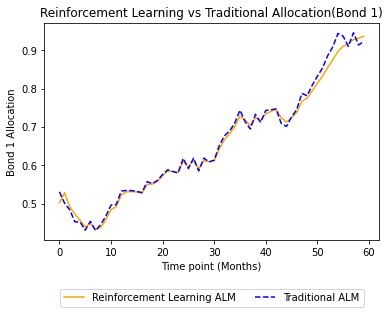

In [500]:
#TEST DATA PERFORMANCE (VISUALISATION)
#Bond 1
test_index = 6
plt.plot(weights_predictions_test[:,test_index],color = "orange",label="Reinforcement Learning ALM")
plt.plot(analytical_weights_test[:,test_index],color = "blue",linestyle='--',label="Traditional ALM")

#legend 
plt.xlabel("Time point (Months)")
plt.ylabel("Bond 1 Allocation")
#plt.ylim(0,1.1)
plt.title("Reinforcement Learning vs Traditional Allocation(Bond 1)")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.show
plt.savefig('output/comp1_allocation1.png', dpi=300, bbox_inches="tight")


<function matplotlib.pyplot.show(close=None, block=None)>

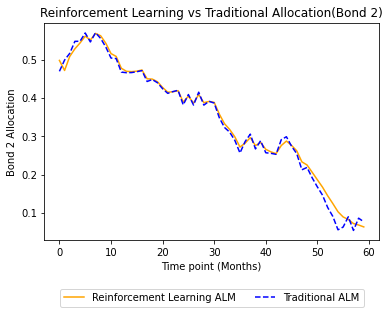

In [501]:
#TEST DATA PERFORMANCE (VISUALISATION)
#Bond 2
plt.plot(1-weights_predictions_test[:,test_index],color = "orange",label="Reinforcement Learning ALM")
plt.plot(1-analytical_weights_test[:,test_index],color = "blue",linestyle='--',label="Traditional ALM")

#legend 
plt.xlabel("Time point (Months)")
plt.ylabel("Bond 2 Allocation")
#plt.ylim(0,1.1)
plt.title("Reinforcement Learning vs Traditional Allocation(Bond 2)")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.show
#plt.savefig('output/comp1_allocation2.png', dpi=300, bbox_inches="tight")

In [392]:
#Test 1 traditional allocation results for table
traditional_result = np.round(analytical_weights_test[[11,23,35,47,59],test_index]*100,2)
traditional_result,100-traditional_result

(array([49.73, 58.02, 74.36, 78.75, 92.32]),
 array([50.27, 41.98, 25.64, 21.25,  7.68]))

In [393]:
#Test 1 RL allocation results for table
rl_result = np.round(weights_predictions_test[[11,23,35,47,59],test_index]*100,2)
rl_result,100-rl_result

(array([49.18, 58.11, 72.82, 76.68, 93.65], dtype=float32),
 array([50.82     , 41.89     , 27.18     , 23.32     ,  6.3499985],
       dtype=float32))

<function matplotlib.pyplot.show(close=None, block=None)>

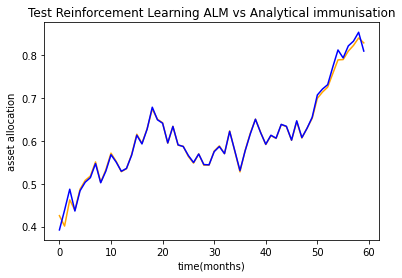

In [126]:
#TEST DATA PERFORMANCE (VISUALISATION)

plt.plot(weights_predictions_test2[:,test_index],color = "orange")
plt.plot(analytical_weights_test2[:,test_index],color = "blue")
#legend 
plt.xlabel("time(months)")
plt.ylabel("asset allocation")
#plt.ylim(0,1.1)
plt.title("Test Reinforcement Learning ALM vs Analytical immunisation")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

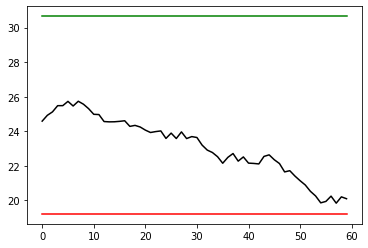

In [377]:
a1_vis = test_data[:,test_index,0]
a2_vis = test_data[:,test_index,1]
l_vis = test_data[:,test_index,2]
plt.plot(a1_vis,color = "red")
plt.plot(a2_vis,color = "green")
plt.plot(l_vis,color = "black")
plt.show


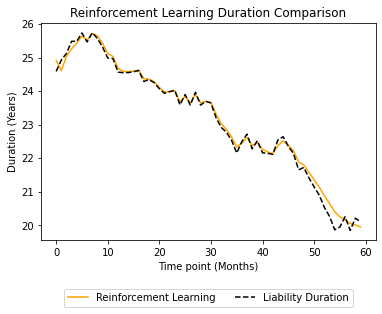

In [421]:
test_asset_duration=weights_predictions_test[:,test_index]*test_data[:,test_index,0] + (1-weights_predictions_test[:,test_index])*test_data[:,test_index,1]
plt.plot(test_asset_duration,color = "orange",label = "Reinforcement Learning")

test_asset_duration_analytical=analytical_weights_test[:,test_index]*test_data[:,test_index,0] + (1-analytical_weights_test[:,test_index])*test_data[:,test_index,1]
#plt.plot(test_asset_duration_analytical,color = "blue")
plt.xlabel("Time point (Months)")
plt.ylabel("Duration (Years)")
#plt.ylim(0,1.1)
plt.title("Reinforcement Learning Duration Comparison")
plt.plot(test_data[:,test_index,2],color = "black", linestyle='--',label = "Liability Duration")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.show
plt.savefig('output/comp1_duration.png', dpi=300, bbox_inches="tight")

In [402]:
#Test 1 Actual duration results for verification
np.round(test_data[[11,23,35,47,59],test_index,2],2)

array([24.97, 24.02, 22.15, 21.65, 20.1 ])

In [404]:
#Test 1 traditional duration results for table
traditional_duration_results=np.round(test_asset_duration_analytical[np.array([11,23,35,47,59])],2) 
traditional_duration_results #exactly the same as the actual 

array([24.97, 24.02, 22.15, 21.65, 20.1 ])

In [406]:
#Test 1 rl duration results for table
rl_duaration_results=np.round(test_asset_duration[np.array([11,23,35,47,59])],2) 
rl_duaration_results

array([25.04, 24.01, 22.33, 21.89, 19.95])

In [410]:
#Test 1 duration results comparison for table
duration_results_difference=rl_duaration_results-traditional_duration_results
duration_results_percentage_difference=duration_results_difference/traditional_duration_results
np.round(duration_results_difference,2),np.mean(duration_results_difference),np.round(duration_results_percentage_difference*100,2),np.mean(duration_results_percentage_difference*100)

(array([ 0.07, -0.01,  0.18,  0.24, -0.15]),
 0.06600000000000036,
 array([ 0.28, -0.04,  0.81,  1.11, -0.75]),
 0.28272437835519)

Diff Mean: -0.0013444044435784867 Diff Std: 0.045755872345146165 CI Lower: -0.09102591424006497 CI Upper: 0.088337105352908


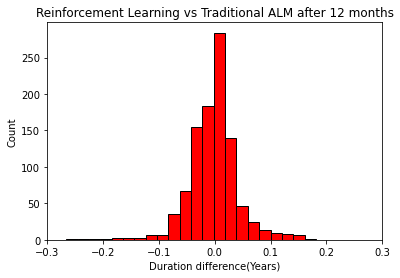

In [455]:
#DURATION DIFFERENCE 1 Year
comparison_time_point = 11
duration_diff_agg=[]
for test_index in np.arange(test_data.shape[1]):
    test_asset_duration=weights_predictions_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-weights_predictions_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-analytical_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg),"Diff Std:",np.std(duration_diff_agg),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Count")
plt.xlim(-0.3,0.3)
plt.title(f"Reinforcement Learning vs Traditional ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg,density=0,bins=30,color="red",ec="black")
plt.savefig(f"output/ag1_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")

Diff Mean: 0.0023072278264143014 Diff Std: 0.06554012750891121 CI Lower: -0.12615142209105168 CI Upper: 0.13076587774388027


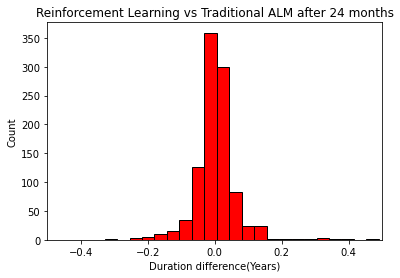

In [456]:
#DURATION DIFFERENCE 2 Years
comparison_time_point = 23
duration_diff_agg=[]
for test_index in np.arange(test_data.shape[1]):
    test_asset_duration=weights_predictions_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-weights_predictions_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-analytical_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_a,
    duration_diff_agg.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg),"Diff Std:",np.std(duration_diff_agg),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Count")
plt.xlim(-0.5,0.5)
plt.title(f"Reinforcement Learning vs Traditional ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg,density=0,bins=30,color="red",ec="black")
plt.savefig(f"output/ag1_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")

Diff Mean: 0.004961041894738145 Diff Std: 0.08240881649785903 CI Lower: -0.15656023844106554 CI Upper: 0.16648232223054182


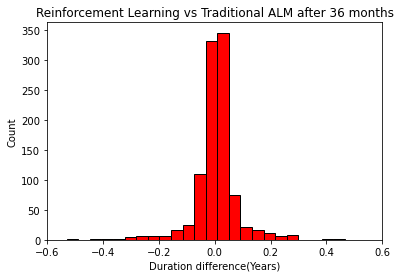

In [457]:
#DURATION DIFFERENCE 3 Years
comparison_time_point = 35
duration_diff_agg=[]
for test_index in np.arange(test_data.shape[1]):
    test_asset_duration=weights_predictions_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-weights_predictions_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-analytical_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg),"Diff Std:",np.std(duration_diff_agg),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Count")
plt.xlim(-0.6,0.6)
plt.title(f"Reinforcement Learning vs Traditional ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg,density=0,bins=30,color="red",ec="black")
plt.savefig(f"output/ag1_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")

Diff Mean: -0.0003445230952352176 Diff Std: 0.1111456220946588 CI Lower: -0.21818994240076645 CI Upper: 0.217500896210296


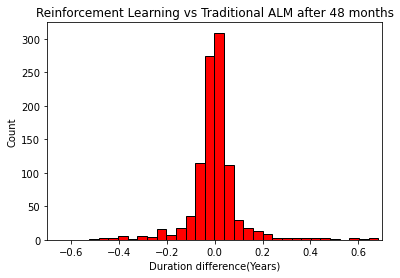

In [454]:
#DURATION DIFFERENCE 4 Years
comparison_time_point = 47
duration_diff_agg=[]
for test_index in np.arange(test_data.shape[1]):
    test_asset_duration=weights_predictions_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-weights_predictions_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-analytical_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg),"Diff Std:",np.std(duration_diff_agg),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Count")
plt.xlim(-0.7,0.7)
plt.title(f"Reinforcement Learning vs Traditional ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg,density=0,bins=30,color="red",ec="black")
plt.savefig(f"output/ag1_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")

Diff Mean: -0.0013785093011106078 Diff Std: 0.1251671371349195 CI Lower: -0.24670609808555283 CI Upper: 0.2439490794833316


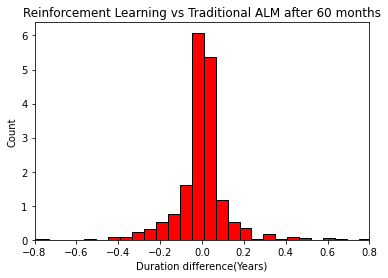

In [458]:
#DURATION DIFFERENCE 5 Years
comparison_time_point = 59
duration_diff_agg=[]
for test_index in np.arange(test_data.shape[1]):
    test_asset_duration=weights_predictions_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-weights_predictions_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-analytical_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg),"Diff Std:",np.std(duration_diff_agg),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Count")
plt.xlim(-0.8,0.8)
plt.title(f"Reinforcement Learning vs Traditional ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg,density=1,bins=30,color="red",ec="black")
plt.savefig(f"output/ag1_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")
#More variation over time but difference is still small

Diff Mean: -0.009397664176952997 Diff Std: 0.12333090972861128 CI Lower: -0.24310709236918873 CI Upper: 0.24035007376696751


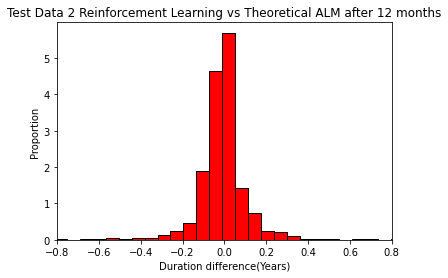

In [495]:
#DURATION DIFFERENCE 2ND TEST DATA
#figure, axis = plt.subplots(2, 2)
comparison_time_point = 11
duration_diff_agg2=[]
for test_index in np.arange(test_data2.shape[1]):
    test_asset_duration=weights_predictions_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-weights_predictions_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-analytical_weights_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg2.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg2),"Diff Std:",np.std(duration_diff_agg2),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg2),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg2))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Proportion")
plt.xlim(-0.8,0.8)
plt.title(f"Test Data 2 Reinforcement Learning vs Theoretical ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg2,density=1,bins=30,color="red",ec="black")
plt.savefig(f"output/ag2_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")


Diff Mean: -0.0020779622120965496 Diff Std: 0.2245770144632824 CI Lower: -0.4415494576491441 CI Upper: 0.4387924390469229


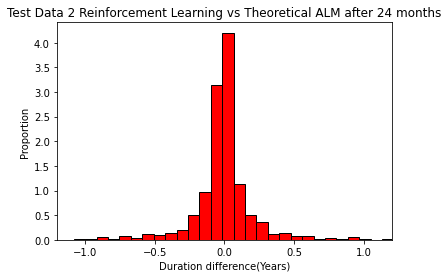

In [496]:
#DURATION DIFFERENCE 2ND TEST DATA
#figure, axis = plt.subplots(2, 2)
comparison_time_point = 23
duration_diff_agg2=[]
for test_index in np.arange(test_data2.shape[1]):
    test_asset_duration=weights_predictions_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-weights_predictions_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-analytical_weights_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg2.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg2),"Diff Std:",np.std(duration_diff_agg2),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg2),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg2))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Proportion")
plt.xlim(-1.2,1.2)
plt.title(f"Test Data 2 Reinforcement Learning vs Theoretical ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg2,density=1,bins=30,color="red",ec="black")
plt.savefig(f"output/ag2_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")

Diff Mean: -0.01176397175992759 Diff Std: 0.29200845178115864 CI Lower: -0.5737150747921815 CI Upper: 0.5709580561899603


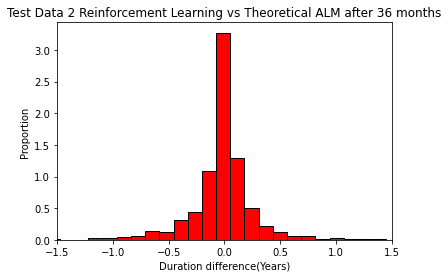

In [497]:
#DURATION DIFFERENCE 2ND TEST DATA
#figure, axis = plt.subplots(2, 2)
comparison_time_point = 35
duration_diff_agg2=[]
for test_index in np.arange(test_data2.shape[1]):
    test_asset_duration=weights_predictions_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-weights_predictions_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-analytical_weights_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg2.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg2),"Diff Std:",np.std(duration_diff_agg2),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg2),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg2))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Proportion")
plt.xlim(-1.5,1.5)
plt.title(f"Test Data 2 Reinforcement Learning vs Theoretical ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg2,density=1,bins=30,color="red",ec="black")
plt.savefig(f"output/ag2_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")

Diff Mean: -0.005993093257692593 Diff Std: 0.3167396339306778 CI Lower: -0.622188191805239 CI Upper: 0.6194311732030178


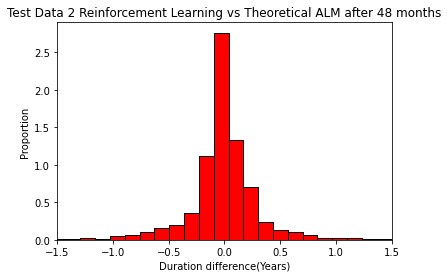

In [498]:
#DURATION DIFFERENCE 2ND TEST DATA
#figure, axis = plt.subplots(2, 2)
comparison_time_point = 47
duration_diff_agg2=[]
for test_index in np.arange(test_data2.shape[1]):
    test_asset_duration=weights_predictions_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-weights_predictions_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-analytical_weights_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg2.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg2),"Diff Std:",np.std(duration_diff_agg2),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg2),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg2))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Proportion")
plt.xlim(-1.5,1.5)
plt.title(f"Test Data 2 Reinforcement Learning vs Theoretical ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg2,density=1,bins=30,color="red",ec="black")
plt.savefig(f"output/ag2_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")

Diff Mean: 0.0148806794352433 Diff Std: 0.3614921160866177 CI Lower: -0.7099030568308813 CI Upper: 0.7071460382286601


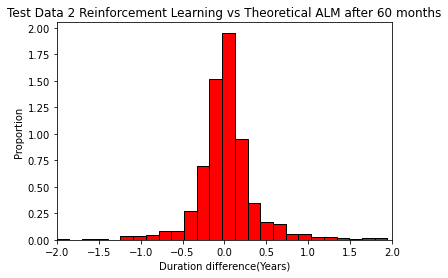

In [499]:
#DURATION DIFFERENCE 2ND TEST DATA
#figure, axis = plt.subplots(2, 2)
comparison_time_point = 59
duration_diff_agg2=[]
for test_index in np.arange(test_data2.shape[1]):
    test_asset_duration=weights_predictions_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-weights_predictions_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    test_asset_duration_analytical=analytical_weights_test2[comparison_time_point,test_index]*test_data2[comparison_time_point,test_index,0] + (1-analytical_weights_test2[comparison_time_point,test_index])*test_data2[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_analytical)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg2.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg2),"Diff Std:",np.std(duration_diff_agg2),"CI Lower:",np.mean(duration_diff_agg)-1.96*np.std(duration_diff_agg2),"CI Upper:",np.mean(duration_diff_agg)+1.96*np.std(duration_diff_agg2))
plt.xlabel("Duration difference(Years)")
plt.ylabel("Proportion")
plt.xlim(-2,2)
plt.title(f"Test Data 2 Reinforcement Learning vs Theoretical ALM after {comparison_time_point+1} months")
plt.hist(duration_diff_agg2,density=1,bins=30,color="red",ec="black")
plt.savefig(f"output/ag2_{comparison_time_point+1}.png", dpi=300, bbox_inches="tight")